## Домашнее задание №6
Самостоятельно обучить классификатор текстов на примере 20newsgroups<br>
На примере 20 newsgroups попробовать разные параметры для сверток для классификации текстов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import datetime as dt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


### Загрузка данных

In [2]:
data_train = fetch_20newsgroups(subset='train', 
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', 
                               shuffle=False)

In [3]:
df_train, df_val, y_train, y_val = train_test_split(pd.DataFrame(data_train.data, columns=['text']),
                                                    data_train.target,
                                                    test_size=0.3, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

df_test = pd.DataFrame(data_test.data, columns=['text'])
y_test = data_test.target

### Предобработка

In [4]:
nltk.download("punkt")
sw = set(get_stop_words("en"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chinyaev.av\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [6]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [7]:
tokens = word_tokenize(train_corpus)

In [8]:
tokens_filtered = [word for word in tokens if word.isalnum()]
dist = FreqDist(tokens_filtered)

In [9]:
def get_vocabulary(max_words):
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
    return vocabulary

In [10]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [11]:
def prepare_data(max_words, max_len):
    vocabulary = get_vocabulary(max_words)
    x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["text"]], dtype=np.int32)
    x_val = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_val["text"]], dtype=np.int32)
    x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["text"]], dtype=np.int32)
    print(f'x_train.shape: {x_train.shape}')
    print(f'x_val.shape: {x_val.shape}')
    print(f'x_test.shape: {x_test.shape}')
    return x_train, x_val, x_test, vocabulary

In [12]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        # B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [15]:

class NewsDataset(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        if self.target is not None:
            y = np.zeros(20, dtype=float)
            y[self.target[index]] = 1
        else:
            y = None
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [16]:
class ModelTrainer():

    def __init__(self,  dataset, net, loss_f,
                 train_preprocessing=None,
                 valid_preprocessing=None,
                 learning_rate=1e-3, 
                 epoch_amount=10, batch_size=12,
                 max_batches_per_epoch=None,
                 device='cpu', early_stopping=10,
                 optim=torch.optim.Adam,
                 params_to_update=None,
                 scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        
        self.optim = optim
        self.params_to_update = params_to_update
        
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.train_preprocessing = train_preprocessing
        self.valid_preprocessing = valid_preprocessing
        
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []
    
    def predict(self, X):
        return self.best_model(X)

    def fit(self, train_dataset, train_labels, valid_dataset, valid_labels):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        if self.params_to_update is not None:
            optimizer = self.optim(self.params_to_update, lr=self.learning_rate)
        else:
            optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(train_dataset, train_labels, self.train_preprocessing)
        val = self.dataset(valid_dataset, valid_labels, self.valid_preprocessing)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') 
        best_ep = 0                  

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

    def save_model(self, PATH):
        torch.save(self.best_model.state_dict(), PATH)

    def load_model(self, PATH):
         self.best_model.load_state_dict(torch.load(PATH))       
        
    def get_clf_results(self, test_dataset, test_labels):
        test = self.dataset(test_dataset, test_labels, self.valid_preprocessing)
        test = DataLoader(test, batch_size=self.batch_size, shuffle=False)
        
        true_labels = []
        pred_labels = []
        with torch.no_grad():
            for batch_X, labels in test:
                true_labels += list(labels.numpy())
                batch_X = batch_X.to(self.device)
                labels = labels.to(self.device)

                outputs = self.predict(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                pred_labels += list(predicted.numpy())
        return true_labels, pred_labels 

In [17]:
net = Net(vocab_size=2000, num_classes=20)
print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=20, bias=True)
)
Parameters: 307860


In [18]:
params = {
    'dataset': NewsDataset,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

cf_1 = ModelTrainer(**params)

In [19]:
x_train, x_val, x_test, vocabulary = prepare_data(2000, 40)

x_train.shape: (7919, 40)
x_val.shape: (3395, 40)
x_test.shape: (7532, 40)


In [20]:
cf_1.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.8874757789796397, 0:00:02.435144 сек
Loss_val: 2.6781766414642334

Эпоха: 1 Loss_train: 2.3962925864804174, 0:00:02.415619 сек
Loss_val: 2.2817933559417725

Эпоха: 2 Loss_train: 1.8877221249764966, 0:00:02.461298 сек
Loss_val: 1.8942584991455078

Эпоха: 3 Loss_train: 1.4696498801631313, 0:00:02.393882 сек
Loss_val: 1.6839516162872314

Эпоха: 4 Loss_train: 1.1623406698626857, 0:00:02.377496 сек
Loss_val: 1.556107997894287

Эпоха: 5 Loss_train: 0.9251579738432362, 0:00:02.384718 сек
Loss_val: 1.4483712911605835

Эпоха: 6 Loss_train: 0.7262483508356156, 0:00:02.535454 сек
Loss_val: 1.3440293073654175

Эпоха: 7 Loss_train: 0.5750639852016203, 0:00:02.642772 сек
Loss_val: 1.310677170753479

Эпоха: 8 Loss_train: 0.44440105413236924, 0:00:02.439764 сек
Loss_val: 1.2812472581863403

Эпоха: 9 Loss_train: 0.34155709176294263, 0:00:02.389430 сек
Loss_val: 1.268249750137329

Эпоха: 10 Loss_train: 0.261081594132608, 0:00:02.492974 сек
Loss_val: 1.2900795936584473

Эпоха: 11 L

In [21]:
true_labels, pred_labels = cf_1.get_clf_results(x_test, y_test)

In [22]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.39      0.38      0.39       319
           1       0.44      0.51      0.47       389
           2       0.56      0.55      0.55       394
           3       0.42      0.44      0.43       392
           4       0.50      0.52      0.51       385
           5       0.58      0.55      0.56       395
           6       0.70      0.66      0.68       390
           7       0.54      0.62      0.58       396
           8       0.75      0.73      0.74       398
           9       0.54      0.58      0.56       397
          10       0.75      0.70      0.72       399
          11       0.69      0.65      0.67       396
          12       0.32      0.36      0.34       393
          13       0.46      0.46      0.46       396
          14       0.64      0.54      0.58       394
          15       0.52      0.60      0.56       398
          16       0.50      0.50      0.50       364
          17       0.78    

### Увеличиваем словарь

In [23]:
net = Net(vocab_size=4000, embedding_dim=256, out_channel=256, num_classes=20)

print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(4000, 256)
  (conv): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=20, bias=True)
)
Parameters: 1226004


In [24]:
x_train, x_val, x_test, vocabulary = prepare_data(4000, 60)

x_train.shape: (7919, 60)
x_val.shape: (3395, 60)
x_test.shape: (7532, 60)


In [25]:
params = {
    'dataset': NewsDataset,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 20, 
    'learning_rate': 1e-3,
    'early_stopping': 5,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

cf_2 = ModelTrainer(**params)

In [26]:
cf_2.fit(x_train, y_train, x_val, y_val)

Эпоха: 0 Loss_train: 2.654599151303691, 0:00:07.457418 сек
Loss_val: 2.00628399848938

Эпоха: 1 Loss_train: 1.5631152872116334, 0:00:07.354720 сек
Loss_val: 1.4237490892410278

Эпоха: 2 Loss_train: 0.9345610074458583, 0:00:07.425584 сек
Loss_val: 1.1586339473724365

Эпоха: 3 Loss_train: 0.5424616432959034, 0:00:07.301839 сек
Loss_val: 1.0400776863098145

Эпоха: 4 Loss_train: 0.29226363306083986, 0:00:07.194603 сек
Loss_val: 0.9063748717308044

Эпоха: 5 Loss_train: 0.1572727723227393, 0:00:07.226031 сек
Loss_val: 0.9226074814796448

Эпоха: 6 Loss_train: 0.08880872291422659, 0:00:07.297754 сек
Loss_val: 0.8930847644805908

Эпоха: 7 Loss_train: 0.05679964778884765, 0:00:07.350462 сек
Loss_val: 0.8643835783004761

Эпоха: 8 Loss_train: 0.04026967232986804, 0:00:07.445818 сек
Loss_val: 0.8778536915779114

Эпоха: 9 Loss_train: 0.030797294310985074, 0:00:07.362241 сек
Loss_val: 0.8554353713989258

Эпоха: 10 Loss_train: 0.024440672549028552, 0:00:07.227669 сек
Loss_val: 0.8585379123687744

Эпох

In [27]:
true_labels, pred_labels = cf_2.get_clf_results(x_test, y_test)

In [28]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       319
           1       0.57      0.59      0.58       389
           2       0.63      0.65      0.64       394
           3       0.62      0.49      0.55       392
           4       0.69      0.67      0.68       385
           5       0.64      0.67      0.66       395
           6       0.67      0.80      0.73       390
           7       0.74      0.69      0.71       396
           8       0.80      0.80      0.80       398
           9       0.72      0.65      0.69       397
          10       0.76      0.77      0.77       399
          11       0.75      0.74      0.74       396
          12       0.42      0.49      0.45       393
          13       0.61      0.59      0.60       396
          14       0.72      0.72      0.72       394
          15       0.53      0.78      0.63       398
          16       0.56      0.67      0.61       364
          17       0.85    

In [29]:
def plot_loss():
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(cf_1.train_loss)), cf_1.train_loss, label='train 1', linestyle='--')
    plt.plot(range(len(cf_1.val_loss)), cf_1.val_loss, marker='o', label='val 1')
    plt.plot(range(len(cf_2.train_loss)), cf_2.train_loss, label='train 2', linestyle='--')
    plt.plot(range(len(cf_2.val_loss)), cf_2.val_loss, marker='o', label='val 2')
    plt.legend()
    plt.show()

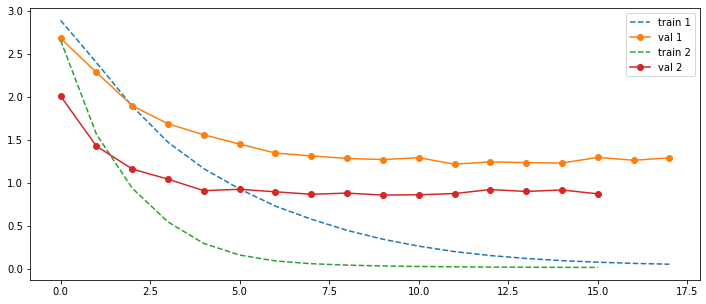

In [30]:
plot_loss()

ВЫВОД: Лучшие результаты показала модель с большим словарем.